<a href="https://colab.research.google.com/github/denboba/Machine-Learning/blob/main/tema/tema1_abdulkadir%20gobena-denboba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [7]:
df_train = pd.read_csv('train.csv',parse_dates=['data_ora'])
df_test = pd.read_csv('test.csv',parse_dates=['data_ora'])

In [8]:
print(df_train.info())
print(df_test.describe())
print(df_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ora               10886 non-null  datetime64[ns]
 1   sezon                  10886 non-null  int64         
 2   sarbatoare             10886 non-null  int64         
 3   zi_lucratoare          10886 non-null  int64         
 4   vreme                  10886 non-null  int64         
 5   temperatura            10886 non-null  float64       
 6   temperatura_resimtita  10886 non-null  float64       
 7   umiditate              10886 non-null  int64         
 8   viteza_vant            10886 non-null  float64       
 9   ocazionali             10886 non-null  int64         
 10  inregistrati           10886 non-null  int64         
 11  total                  10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 102

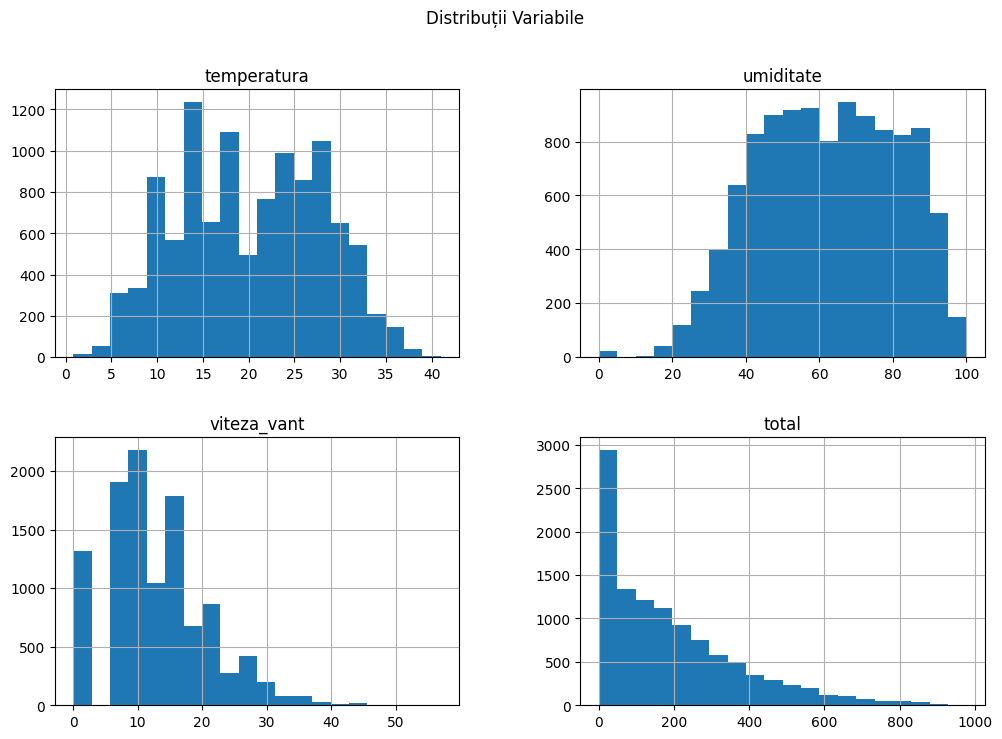

In [9]:
df_train[['temperatura', 'umiditate', 'viteza_vant', 'total']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribuții Variabile')
plt.show()